In [1]:
import sys
import ssl
import urllib.request
from io import StringIO

from copy import deepcopy
import os
from os import getcwd
from os.path import dirname, join
from sklearn.neighbors import KNeighborsRegressor
from scipy.optimize import minimize, basinhopping


import datetime
from sklearn import preprocessing



import csv
import json

# Load Json File
# Load the arguments
with open('arguments.json', 'r') as fid:
    arguments = json.load(fid)




import matplotlib.pyplot as plt
import numpy as np
import scipy 
import pandas as pd
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

SRC_DIR = '../../mammal/MAMMAL' # relative path to MAMMAL library 
sys.path.append(SRC_DIR)
BASE_DIR = getcwd() # get current directory with files
DATA_DIR = join(BASE_DIR, arguments['data_dir'])
TEST_DIR = join(DATA_DIR, 'test') # directory with intermagnet data
EXAM_DIR = join(DATA_DIR, 'diurnal_test_data') # second day intermagnet data to test parameters

import Diurnal
from Parse import parseIM as pi
from Utils import ProcessingUtils as pu
from Utils import Filters as filt

# Create Output CSV File
out_file = open(arguments['csv_file'], mode = 'a', encoding='UTF8')

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10) # (w, h)#

# Determine Day Ranges for Training and Testing Data Sets

In [2]:
obj = os.walk(TEST_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tra = x[0]
end_tra = x[len(x)-1]

# Do It again for Testing Data 
obj = os.walk(EXAM_DIR)
date_names = []
file_names = []
for _, _, files in obj:
    for file in files:
        if(file[16:] == 'min'):
            file_names.append(file[3:11])

x = sorted(file_names)
#print(x)
start_tst = x[0]
end_tst = x[len(x)-1]

# Load INTERMAGNET Data

/home/antuser/anaconda3/envs/envp39/lib/python3.9/site-packages/pandas-1.3.4-py3.9-linux-x86_64.egg/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Loaded bou20221207dmin.min
Loaded frd20221207dmin.min
Loaded bou20221204dmin.min
Loaded frd20221204dmin.min
Loaded bou20221129dmin.min
Loaded frd20221129dmin.min
Loaded frd20221128dmin.min
Loaded bou20221128dmin.min
Loaded frd20221205dmin.min
Loaded bou20221205dmin.min
Loaded frd20221130dmin.min
Loaded bou20221130dmin.min
Loaded bou20221201dmin.min
Loaded frd20221201dmin.min
Loaded bou20221202dmin.min
Loaded frd20221202dmin.min
Loaded frd20221206dmin.min
Loaded bou20221206dmin.min
Loaded bou20221203dmin.min
Loaded frd20221203dmin.min


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 141.79it/s]


            DATE     TIME  DOY        X       Y        Z         F  \
0     2022-11-28      0.0  332  20491.4  2909.1  47134.7  51478.34   
1     2022-11-28     60.0  332  20491.2  2909.4  47134.8  51478.27   
2     2022-11-28    120.0  332  20491.1  2909.5  47134.8  51478.24   
3     2022-11-28    180.0  332  20490.7  2909.9  47134.8  51478.10   
4     2022-11-28    240.0  332  20490.6  2910.2  47134.8  51478.08   
...          ...      ...  ...      ...     ...      ...       ...   
1435  2022-12-07  86100.0  341  20491.2  2910.3  47135.9  51479.33   
1436  2022-12-07  86160.0  341  20491.2  2910.5  47135.9  51479.34   
1437  2022-12-07  86220.0  341  20491.2  2911.1  47135.9  51479.27   
1438  2022-12-07  86280.0  341  20491.2  2911.7  47136.0  51479.50   
1439  2022-12-07  86340.0  341  20491.8  2911.8  47136.0  51479.74   

                datetime     epoch_sec    LAT     LONG     ALT        IGRF_X  \
0    2022-11-28 00:00:00  1.669594e+09  40.14 -105.241  1682.0  20530.642665   

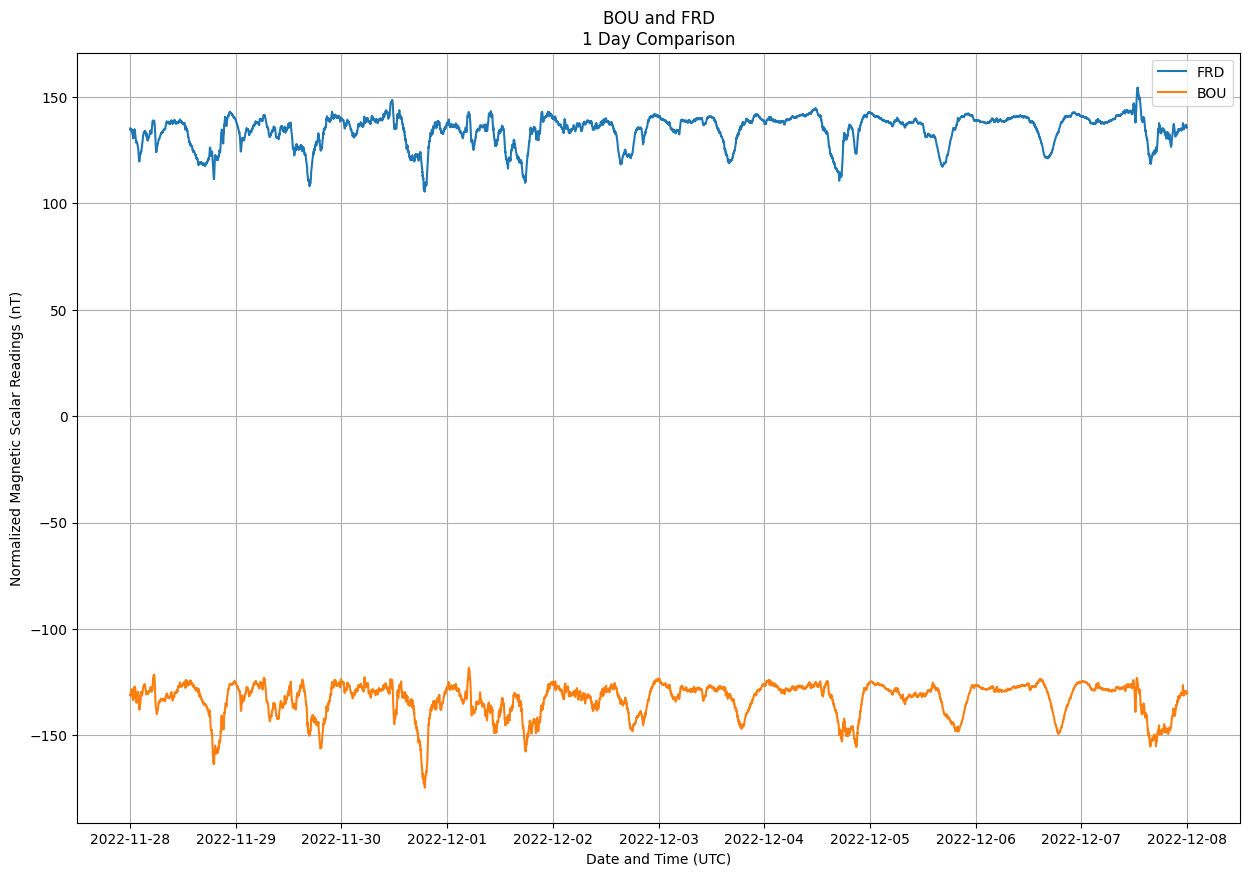

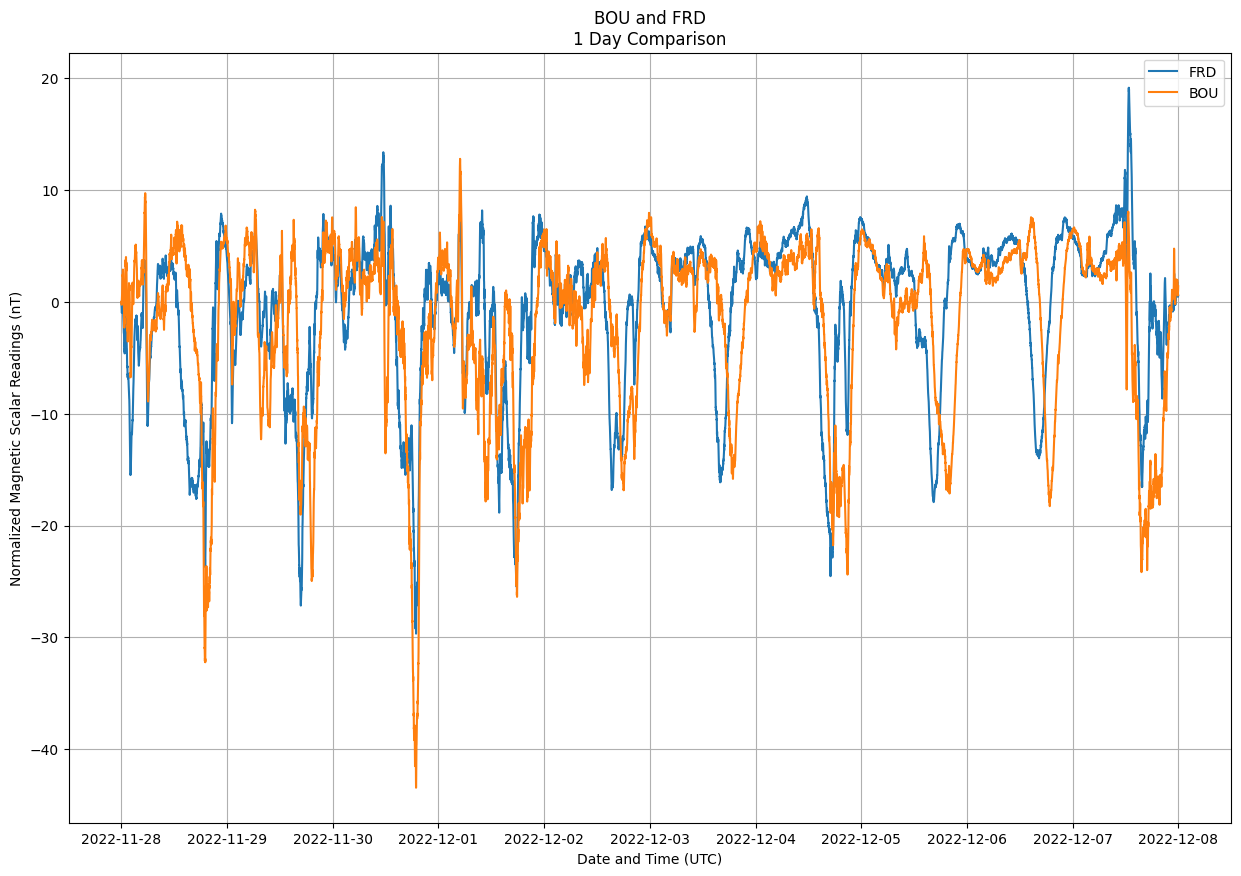

In [3]:
df_dict = pi.loadInterMagData(TEST_DIR, fast_mode = False, second = False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df   = df_dict[to_name]


to_df = pu.reject_outliers(to_df,
                           window_size=200,
                           std_lim=3)

print(from_df)
to_IGRF_f   = np.array(to_df.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df.F)
from_f = np.array(from_df.F)
    
to_f_no_core   = np.array(to_df.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df.epoch_sec)
from_t = np.array(from_df.epoch_sec)

plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()
    
plt.figure()
plt.title(from_name + ' and ' + to_name + '\n1 Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core - to_f_no_core[0], label=to_name)
plt.plot(from_df.datetime, from_f_no_core - from_f_no_core[0], label=from_name)
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core, from_f_no_core[:len(to_f)])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers
# print('RMSE:', pu.rmse(to_f_no_core - to_f_no_core[0], from_f_no_core[:len(to_f)] - from_f_no_core[0])) # Extra slicing needed because dimensions don't match as a result of rejecting outliers

# Simple Longitude Normalization

RMSE: 267.49328781625104


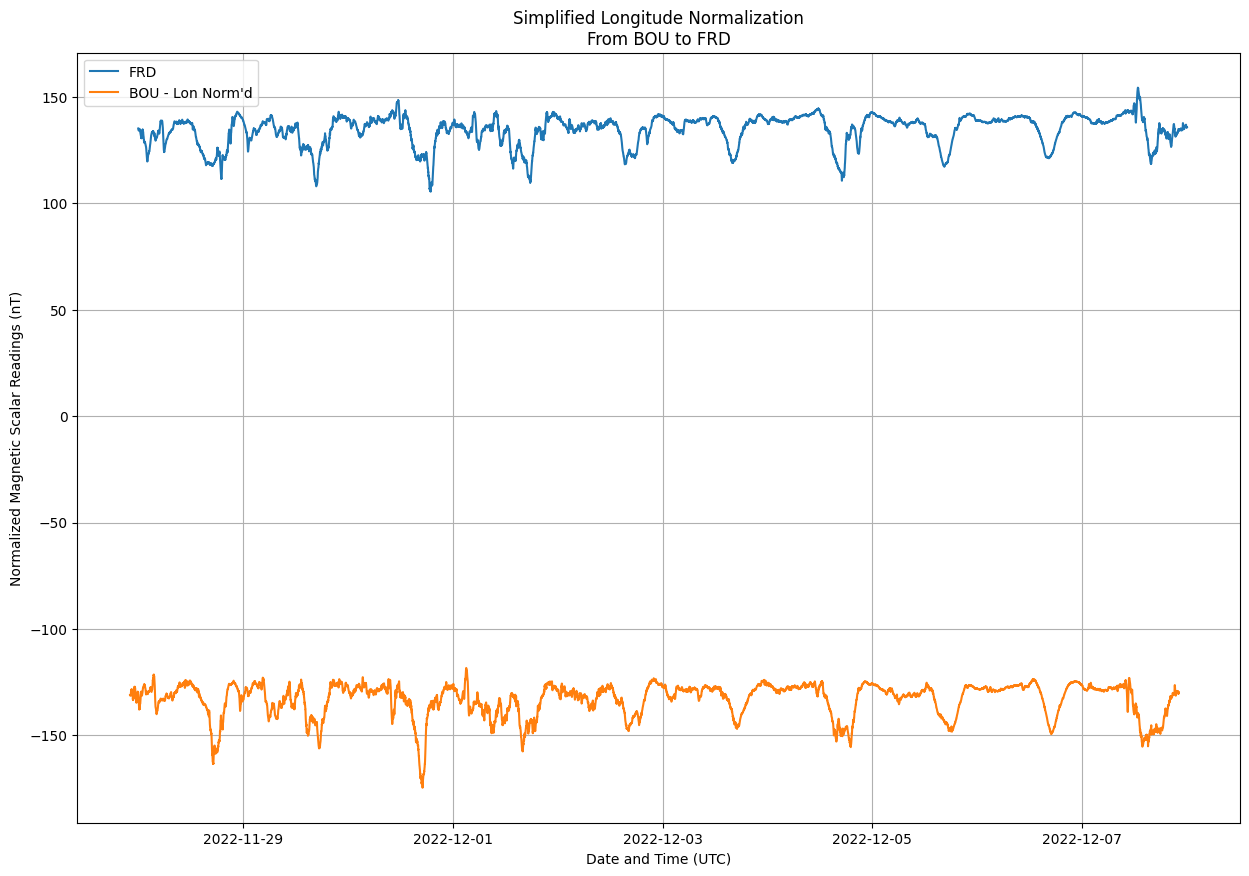

In [4]:
lon_diff     = from_df.LONG.mean() - to_df.LONG.mean()
lon_t_offset = pd.Timedelta(seconds=lon_diff / (Diurnal.E_ROT_DEG_S))
bou_shift_t  = from_df.epoch_sec + lon_t_offset.total_seconds()

plt.figure()
plt.title('Simplified Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.datetime, to_f_no_core, label=to_name)
plt.plot(from_df.datetime + lon_t_offset, from_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

interp_lpf = interpolate.interp1d(bou_shift_t, from_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= bou_shift_t.min(), to_t <= bou_shift_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

bou_shift_interp = interp_lpf(interp_t)

print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
                       bou_shift_interp))

# Frequency-Based Longitude Normalization

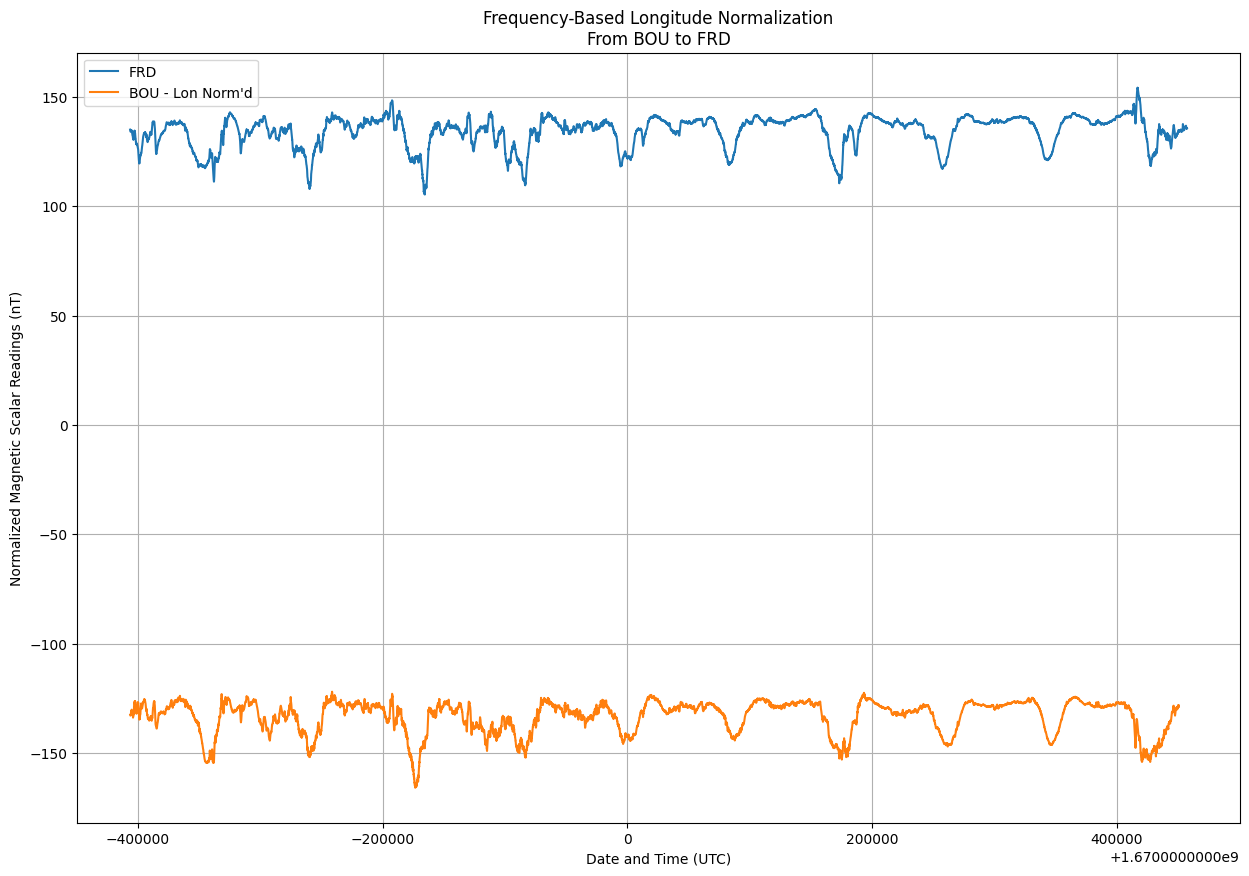

In [5]:
from_combined_t, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second = False)
from_combined_f_no_core = from_combined_f - from_IGRF_f

plt.figure()
plt.title('Frequency-Based Longitude Normalization\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec, to_f_no_core, label=to_name)
plt.plot(from_combined_t, from_combined_f_no_core, label='{} - Lon Norm\'d'.format(from_name))
plt.legend()
plt.grid()

# print('RMSE:', pu.rmse(to_f_no_core[interp_mask],
#                        from_combined_f_no_core[:len(to_f_no_core[interp_mask])]))

# Neural Network Approach

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler

# create models

class ERSM_NN(nn.Module):
    __scaler = StandardScaler() # create scaler
    
    def __init__(self, n_hidden=10, d_in=4, d_out=1, d_hidden=50, drop_per=0.5, batch_size=1000):
        super(ERSM_NN, self).__init__()
        
        d_hide_out = d_in + d_hidden
        linear_ReLU_layers = []
        
        linear_ReLU_layers.append(nn.Linear(d_in, d_hidden))
        linear_ReLU_layers.append(nn.BatchNorm1d(d_hidden))
        linear_ReLU_layers.append(nn.Dropout(drop_per))
            
        for i in range(1,n_hidden):
            linear_ReLU_layers.append(nn.ReLU())
            linear_ReLU_layers.append(nn.Linear(d_hide_out,d_hidden))
            d_hide_out += d_hidden
            linear_ReLU_layers.append(nn.BatchNorm1d(d_hidden))
            
        # Add Output Layer
        linear_ReLU_layers.append(nn.ReLU())
        linear_ReLU_layers.append(nn.Linear(d_hide_out, int(d_hide_out/10)))
        linear_ReLU_layers.append(nn.BatchNorm1d(int(d_hide_out/10)))
        linear_ReLU_layers.append(nn.ReLU())
        linear_ReLU_layers.append(nn.Linear(int(d_hide_out/10),d_out))
        
        # Convert List of Layers to Compatible Type
        self.layers = torch.nn.ModuleList(linear_ReLU_layers)
        
        self.__batch_size = batch_size
        self.__n_hidden = n_hidden
        
        self.double() # dtype

    
    def forward(self,x):
        skip_connect = False
        y = None
        i = 0
        for layer in self.layers:
            #print(str(layer), i+1 < self.__n_hidden, isinstance(layer, nn.BatchNorm1d), i+1)
            if (i < self.__n_hidden and isinstance(layer, nn.Linear)):
                skip_connect = True
                y = layer(x)
                i+=1
            elif skip_connect and isinstance(layer, nn.BatchNorm1d):
                x = torch.cat((layer(y), x),1)
                skip_connect = False
            else:
                x = layer(x)
            
        return x
    
    def process_training_data(self, time, from_mag, to_mag, augment=False, num_agument = 10000):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        to_data = to_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= map_kp_data(time, kp_df, quiet=True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        if augment==True:
            bootstrap_indices = np.random.randint(data_set.shape[0], size = 10000)
            Xtr_augment = np.copy(data_set)
            ytr_augment = np.copy(np.vstack(to_data))

            for i in bootstrap_indices:
                new_sample = np.random.normal(loc=data_set[i,:], scale=0.0)
                Xtr_augment = np.append(Xtr_augment, [new_sample], axis = 0)
                ytr_augment = np.append(ytr_augment, to_data[i])
            data_set = Xtr_augment
            to_data = ytr_augment
        
        
        
        self.__Xtr = torch.tensor(self.__scaler.fit_transform(data_set), dtype=torch.float64)
        self.__ytr = torch.tensor(np.vstack((to_data)), dtype=torch.float64)
        print(self.__Xtr.dtype)
        print(self.__Xtr.shape, self.__ytr.shape)
        train_ds = torch.utils.data.TensorDataset(self.__Xtr, self.__ytr)
        self.__train_loader = torch.utils.data.DataLoader(train_ds,batch_size=self.__batch_size, shuffle = True) 
        return self.__train_loader, train_ds, self.__Xtr, self.__ytr
                 
    def process_testing_data(self, time, from_mag, to_mag):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        to_data = to_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= map_kp_data(time, kp_df, quiet=True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        self.__Xts = torch.tensor(self.__scaler.transform(data_set), dtype=torch.float64)
        self.__yts = torch.tensor(np.vstack((to_mag)), dtype=torch.float64)
        test_ds = torch.utils.data.TensorDataset(self.__Xts, self.__yts)
        self.__test_loader = torch.utils.data.DataLoader(test_ds,batch_size=self.__batch_size) 
        return self.__test_loader, test_ds, self.__Xts, self.__yts
    
    def x_tensor(self, time, from_mag):
        time_data = np.fmod(time, 24*3600)
        from_data = from_mag
        derivative_data = self.time_derivative(from_mag, time)
                 
        ## Get KP Data
        start_date, end_date = self.get_start_end_date(time)
        kp_df = self.get_KP_data(start_date, end_date)
        kp_data= map_kp_data(time, kp_df, quiet=True)
                 
        data_set = np.vstack((time_data, kp_data, derivative_data, from_data)).T
        
        Xts = torch.tensor(self.__scaler.transform(data_set), dtype=torch.float64)
        return Xts
            
                 
    def get_KP_data(self, start_date, end_date):
        df = pd.DataFrame()
        link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

        ctx = ssl.create_default_context()
        ctx.check_hostname = False
        ctx.verify_mode = ssl.CERT_NONE
        data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


        df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

        y_arr = list(df['Year'])
        m_arr = list(df['Month'])
        d_arr = list(df['Day'])

        num_points = len(y_arr)

        hour_float_arr = list(df['Start-Time'])
        h_arr = list(map(int,hour_float_arr))

        min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
        min_arr = list(map(int, min_float_arr))

        sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
        sec_arr = list(map(int, sec_float_arr))

        num_points = len(y_arr)
        datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


        df['datetime'] = datetime_arr
        df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

        return df


    def map_kp_data(self, time_series, kp_df, quiet = True):
        time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
        kp_array = time_to_kp(time_series)

        if quiet == False:
            return kp_array

        num_points = len(kp_array)
        mag_storm_thresh = 4
        kp_bool = np.empty(num_points, dtype='bool')

        for i in range(num_points):
            kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)

        # convert bool to float 
        return kp_bool.astype(float)
    


    def get_start_end_date(self, time):
        min_date = datetime.datetime.fromtimestamp(min(time))
        min_date -= datetime.timedelta(days=1)
        max_date = datetime.datetime.fromtimestamp(max(time))
        max_date += datetime.timedelta(days=1)

        min_date_str = min_date.strftime('%Y-%m-%d')
        max_date_str = max_date.strftime('%Y-%m-%d')

        return min_date_str, max_date_str

    def time_derivative(self, mag_array, time_array):
        n = len(mag_array)
        dxdt = []
        # Handle First Point With Forward Approximator
        dxdt.append((mag_array[1]-mag_array[0])/(time_array[1]-time_array[0]))

        # Handle Middle Points with Centered Approximator
        i = 1
        while i < n-1:
            dxdt.append((mag_array[i+1] - mag_array[i-1])/(time_array[i+1] - time_array[i-1]))
            i += 1

        # Handle Last Point  With Backward Approximator
        dxdt.append((mag_array[i]-mag_array[i-1])/(time_array[i]-time_array[i-1]))
        return np.array(dxdt)

# Utility Methods

In [7]:
def down_sample(array, fs=1/60):
    array_fft = np.fft.rfft(array)[0:int(len(array)*fs)]*(2*fs)
    return np.fft.irfft(array_fft) 

def get_KP_data(start_date, end_date):
    df = pd.DataFrame()
    link = 'https://kp.gfz-potsdam.de/kpdata?startdate=' + start_date + '&enddate=' + end_date + '&format=kp2#kpdatadownload-143'

    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE
    data = StringIO(urllib.request.urlopen(link, context=ctx).read().decode('utf-8'))


    df[['Year', 'Month', 'Day', 'Start-Time', 'Mid-Time', 'Days_Since_Start_UT_Day', 'Days_Since_Mid_UT_Day', 'Kp', 'ap', 'Definitive']] = pd.read_csv(data, sep ="\s+") 

    y_arr = list(df['Year'])
    m_arr = list(df['Month'])
    d_arr = list(df['Day'])

    num_points = len(y_arr)

    hour_float_arr = list(df['Start-Time'])
    h_arr = list(map(int,hour_float_arr))

    min_float_arr = [(hour_float_arr[i] - h_arr[i])*60 for i in range(num_points)]
    min_arr = list(map(int, min_float_arr))

    sec_float_arr = [(min_float_arr[i] - min_arr[i])*60 for i in range(num_points)]
    sec_arr = list(map(int, sec_float_arr))

    num_points = len(y_arr)
    datetime_arr = [datetime.datetime(y_arr[i],m_arr[i],d_arr[i],h_arr[i],min_arr[i],sec_arr[i],0) for i in range(num_points)]


    df['datetime'] = datetime_arr
    df['epoch_sec'] = (df['datetime'] - pd.Timestamp('1970-01-01')).dt.total_seconds()

    return df


def map_kp_data(time_series, kp_df, quiet = True):
    time_to_kp = interpolate.interp1d(list(kp_df['epoch_sec']),list(kp_df['Kp']),kind='previous')
    kp_array = time_to_kp(time_series)

    if quiet == False:
        return kp_array

    num_points = len(kp_array)
    mag_storm_thresh = 4
    kp_bool = np.empty(num_points, dtype='bool')

    for i in range(num_points):
        kp_bool[i] = ~(kp_array[i] >= mag_storm_thresh)


    return kp_bool


def get_start_end_date(time):
    min_date = datetime.datetime.fromtimestamp(min(time))
    min_date -= datetime.timedelta(days=1)
    max_date = datetime.datetime.fromtimestamp(max(time))
    max_date += datetime.timedelta(days=1)

    min_date_str = min_date.strftime('%Y-%m-%d')
    max_date_str = max_date.strftime('%Y-%m-%d')

    return min_date_str, max_date_str

def minmax(array):
    return [min(array),max(array)]


def different_time_rmse(truth_time, truth_mag, predict_time, predict_mag, break_up=None):
    #ensure np array
    truth_time = np.array(truth_time)
    predict_time = np.array(predict_time)
    
    truth_mag = np.array(truth_mag)
    predict_mag = np.array(predict_mag)
    
    #get overlap range 
    minmax_truth_time = minmax(truth_time)
    minmax_predict_time = minmax(predict_time)

    min_t = max(minmax_truth_time[0], minmax_predict_time[0])
    max_t = min(minmax_truth_time[1], minmax_predict_time[1])
    
    #get mask for overlap range of truth_time 
    time_mask = np.logical_and(truth_time >= min_t, truth_time <= max_t)

    #interpolation model for predict_time, predict_mag
    print(predict_time.shape, predict_mag.shape)
    interp_predict = interpolate.interp1d(predict_time, predict_mag, 'cubic', fill_value='extrapolate')
    
    #Interpolate At Specific Times
    predict_mag_interp = interp_predict(truth_time[time_mask])
    truth_truncated = truth_mag[time_mask]
    
    if break_up is None:
        return pu.rmse(truth_truncated, predict_mag_interp)
    
    rmse_array = [0,0]
    
    if break_up == 'Kp':
        epoch_overlap = truth_time[time_mask]
        start_date, end_date = get_start_end_date(epoch_overlap)
        kp_df = get_KP_data(start_date, end_date)
        kp_mask = map_kp_data(epoch_overlap, kp_df)
        #Quiet Kp
        rmse_array[0] = pu.rmse(truth_truncated[kp_mask], predict_mag_interp[kp_mask])
        
        #High Space Weather Analysis
        try:
            rmse_array[1] = pu.rmse(truth_truncated[~kp_mask], predict_mag_interp[~kp_mask])
        except:
            rmse_array[1] = float("nan")
        return rmse_array
    
    rmse_array = []
    if break_up == 'day':
        epoch_overlap = truth_time[time_mask]
        max_sec = 24*3600
        days = np.fmod(epoch_overlap, max_sec)
        max_index = len(days) -1
        break_up_array = [0]
        i = 0
        while i < max_index:
            if days[i+1] < days[i]:
                break_up_array.append(i)
                break_up_array.append(i+1)
            i += 1
        break_up_array.append(max_index)
        
        divisions = len(break_up_array)
        j = 0
        while j < divisions:
            min_range = break_up_array[j]
            max_range = break_up_array[j+1]
            rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
            j += 2
        return rmse_array
        
    length = len(predict_mag_interp)
    for i in range(break_up):
        min_range = int(i*length/break_up)
        max_range = int((i+1)*length/break_up)
        rmse_array.append(pu.rmse(truth_truncated[min_range:max_range],predict_mag_interp[min_range:max_range]))
    
    return rmse_array

# Create Neural Network Model

In [8]:
batch_size=1000
neural_net = ERSM_NN(n_hidden = 8, d_hidden = 30, batch_size=1000, drop_per = 0.40)
print(str(neural_net))

ERSM_NN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=30, bias=True)
    (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.4, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=34, out_features=30, bias=True)
    (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=30, bias=True)
    (8): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=94, out_features=30, bias=True)
    (11): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=124, out_features=30, bias=True)
    (14): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=154, out_features=30, bias=True)
    (17): BatchNorm1d(30, eps=1e-05

# Linear Regression (Training)

In [9]:
# Linear Regression Method    
interp_combined = interpolate.interp1d(from_combined_t, from_combined_f_no_core, 'cubic')

interp_mask = np.logical_and(to_t >= from_combined_t.min(), to_t <= from_combined_t.max())
interp_t    = to_t[interp_mask] # Clip interpolation times

from_combined_interp = interp_combined(interp_t)

offset, scale = Diurnal.calibrate([0, 1], from_combined_interp, to_f_no_core[interp_mask])
from_combined_opt_f = Diurnal.apply_cal([offset, scale], from_combined_f_no_core)

print('Optimal scale:',  scale)
print('Optimal offset:', offset)

# Create Neural Net Training Data Set: 
train_loader, train_ds, Xtr, ytr = neural_net.process_training_data(interp_t, from_combined_interp, to_f_no_core[interp_mask], augment = False)

Optimal scale: 0.7087349558496815
Optimal offset: 228.65187558009103
torch.float64
torch.Size([14267, 4]) torch.Size([14267, 1])


# Linear Regression (Prediction) 

Loaded frd20221214dmin.min
Loaded bou20221214dmin.min
Loaded bou20221211dmin.min
Loaded frd20221211dmin.min
Loaded frd20221212dmin.min
Loaded bou20221212dmin.min
Loaded bou20221209dmin.min
Loaded frd20221209dmin.min
Loaded bou20221213dmin.min
Loaded frd20221213dmin.min
Loaded frd20221210dmin.min
Loaded bou20221210dmin.min
Loaded bou20221208dmin.min
Loaded frd20221208dmin.min


100%|████████████████████████████████████████████| 6/6 [00:00<00:00, 147.42it/s]


[228.65187558009103, 0.7087349558496815]


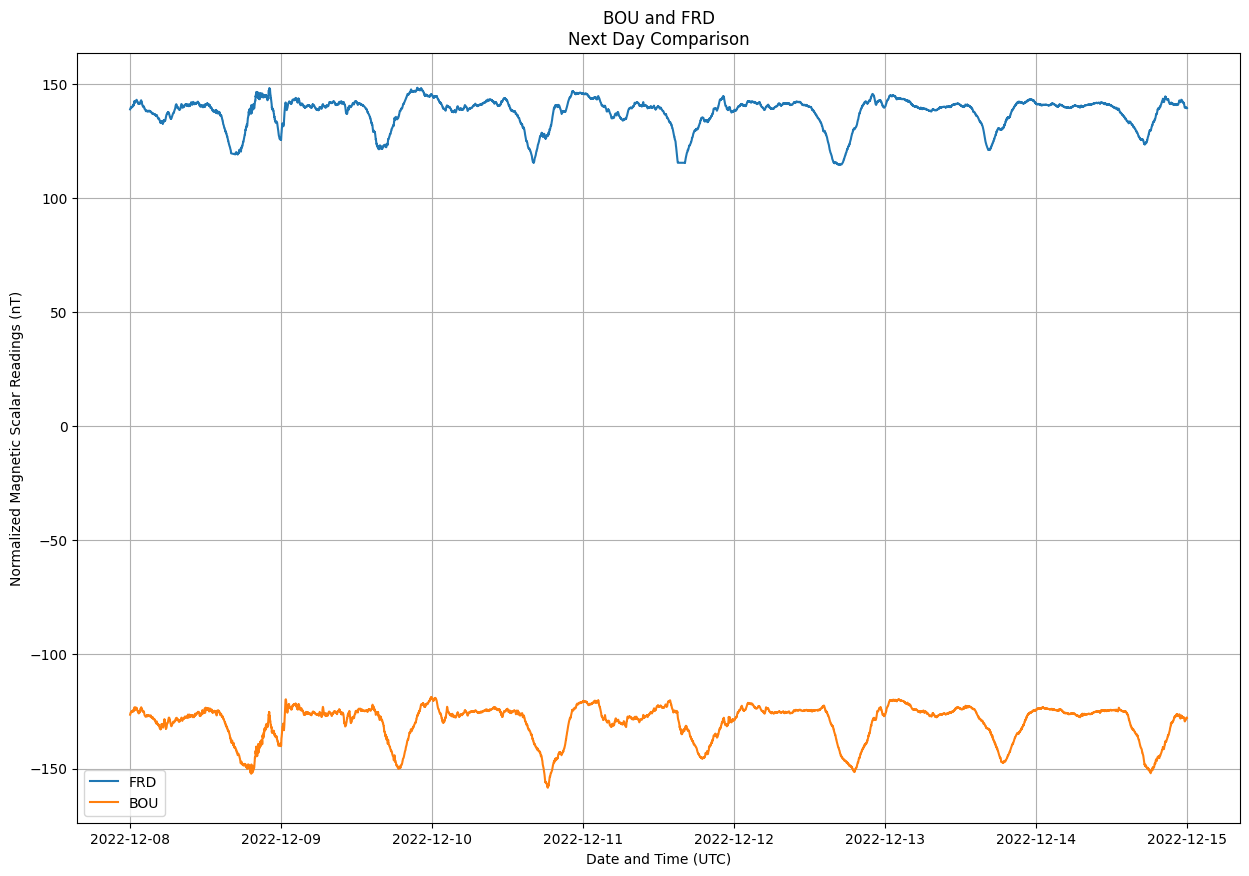

In [10]:
df_dict = pi.loadInterMagData(EXAM_DIR, second=False)

from_name = arguments['from_data'] # data from 'extended' station
to_name   = arguments['to_data'] # data at location to estimate

from_df = df_dict[from_name]
to_df_pred   = df_dict[to_name]

to_df_pred = pu.reject_outliers(to_df_pred,
                           window_size=2000,
                           std_lim=3)

to_IGRF_f   = np.array(to_df_pred.IGRF_F)[0]
from_IGRF_f = np.array(from_df.IGRF_F)[0]

to_f   = np.array(to_df_pred.F)
from_f = np.array(from_df.F)
    
to_f_no_core_pred   = np.array(to_df_pred.F) - to_IGRF_f
from_f_no_core = np.array(from_df.F) - from_IGRF_f
    
to_t   = np.array(to_df_pred.epoch_sec)
from_t = np.array(from_df.epoch_sec)


plt.figure()
plt.title(from_name + ' and ' + to_name + '\nNext Day Comparison')
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Normalized Magnetic Scalar Readings (nT)')
plt.plot(to_df_pred.datetime, to_f_no_core_pred, label=to_name)
plt.plot(from_df.datetime, from_f_no_core, label=from_name)
plt.legend()
plt.grid()


from_combined_t_pred, from_combined_f, _, _ , _ = Diurnal.longitude_norm(from_df, to_df.LONG.mean(), second=False)
from_combined_f_no_core_pred = from_combined_f - from_IGRF_f


interp_combined = interpolate.interp1d(from_combined_t_pred, from_combined_f_no_core_pred, 'cubic')

interp_mask_pred = np.logical_and(to_t >= from_combined_t_pred.min(), to_t <= from_combined_t_pred.max())
interp_t_pred    = to_t[interp_mask_pred] # Clip interpolation times

from_combined_interp_pred = interp_combined(interp_t_pred)

print([offset, scale])
from_combined_opt_f_pred = Diurnal.apply_cal([offset, scale], from_combined_f_no_core_pred)

# Create Neural Net Prediction Data Set: 
test_loader, test_ds, Xts, yts = neural_net.process_testing_data(interp_t_pred, from_combined_interp_pred, to_f_no_core_pred[interp_mask_pred])

# Training Neural Net

In [11]:
# TODO Run Training Code: 
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch import sqrt

lr = 5e-1
num_epoch = 500 # Change this later 


loss_hist = []
val_rmse_hist = []

# TODO
# opt = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()



for model in [neural_net]:
    opt = optim.AdamW(model.parameters(), lr=lr) # Create optimizer with selected learning rate
    scheduler = ExponentialLR(opt, gamma=0.99)
    
    a_tr_loss = []
    a_tr_rmse = []
    a_ts_loss = []
    a_ts_rmse = []

    for epoch in range(num_epoch):
        model.train() # Model is set in training mode
        sum_rmse = 0 # initialize correct counter
        total = 0 # initialize total counter

        batch_loss_tr = [] # Array to store loss for each batch
        for train_iter, data in enumerate(train_loader):
            x_batch,y_batch = data # separate input and outputs
            #y_batch = y_batch.type(torch.long) 
            out = model(x_batch)

            loss = criterion(out,y_batch) #criterion for predicted vs truth
            batch_loss_tr.append(loss.item()) # Add Loss to batch loss


            # Compute gradients using back propagation
            opt.zero_grad() # Sets all gradients to 0
            loss.backward() # Apply backwards propogation to calculate gradient

            # Take an optimization 'step'
            opt.step()
            sum_rmse += loss.item()*y_batch.size()[0]
            total += y_batch.size()[0]

        a_tr_loss.extend(batch_loss_tr) # Add batch losses to a_tr_loss
        a_tr_rmse.append(np.sqrt(sum_rmse/total)) # Add Average RMSE Over Epoch
    
        scheduler.step()
        
        model.eval() # put model in evaluation mode

        sum_rmse = 0 # Reset correct number counter
        total = 0 # Reset total counter

        batch_loss_ts = []
        with torch.no_grad():
            # Why is test set not calculated all at once - why do we use a for loop? 
            for data in test_loader:
                Xts_nn, yts_nn = data # Separate test data
                #yts_nn = yts_nn.type(torch.long) 
                outputs = model(Xts_nn) #Get predictions

                test_loss = criterion(outputs,yts_nn).item()
                batch_loss_ts.append(test_loss) #Get loss of predictions

                sum_rmse += loss.item()*yts_nn.size()[0]
                total += yts_nn.size()[0]

        a_ts_loss.append(np.mean(batch_loss_ts)) # Is average of losses = loss if test_set was done all at once
        a_ts_rmse.append(np.sqrt(sum_rmse/total)) # Calculate accuracy for fold
        
        if(epoch%10==0):
            print('Epoch {0:d}: RMSE {1:.4f}'.format(epoch, np.sqrt(sum_rmse/total)))
        
    loss_hist.append(a_tr_loss)
    val_rmse_hist.append(a_ts_rmse)


Epoch 0: RMSE 35.9285
Epoch 10: RMSE 4.7687
Epoch 20: RMSE 4.6032
Epoch 30: RMSE 4.7360
Epoch 40: RMSE 4.5352
Epoch 50: RMSE 4.4234
Epoch 60: RMSE 3.6970
Epoch 70: RMSE 3.5238
Epoch 80: RMSE 4.3458
Epoch 90: RMSE 3.8027
Epoch 100: RMSE 4.4387
Epoch 110: RMSE 4.2223
Epoch 120: RMSE 4.2482
Epoch 130: RMSE 4.4064
Epoch 140: RMSE 3.9988
Epoch 150: RMSE 3.5496
Epoch 160: RMSE 4.2321
Epoch 170: RMSE 3.7807
Epoch 180: RMSE 4.0400
Epoch 190: RMSE 4.7389
Epoch 200: RMSE 3.8868
Epoch 210: RMSE 3.6913
Epoch 220: RMSE 3.8689
Epoch 230: RMSE 4.2227
Epoch 240: RMSE 3.5442
Epoch 250: RMSE 4.0453
Epoch 260: RMSE 3.8963
Epoch 270: RMSE 3.6565
Epoch 280: RMSE 3.9682
Epoch 290: RMSE 3.6721
Epoch 300: RMSE 3.9248
Epoch 310: RMSE 4.3775
Epoch 320: RMSE 3.8948
Epoch 330: RMSE 3.8919
Epoch 340: RMSE 3.7039
Epoch 350: RMSE 3.5420
Epoch 360: RMSE 4.1786
Epoch 370: RMSE 4.3613
Epoch 380: RMSE 3.4577
Epoch 390: RMSE 4.3057
Epoch 400: RMSE 4.0605
Epoch 410: RMSE 3.8348
Epoch 420: RMSE 3.6758
Epoch 430: RMSE 3.881

# Model Performance over Epoch

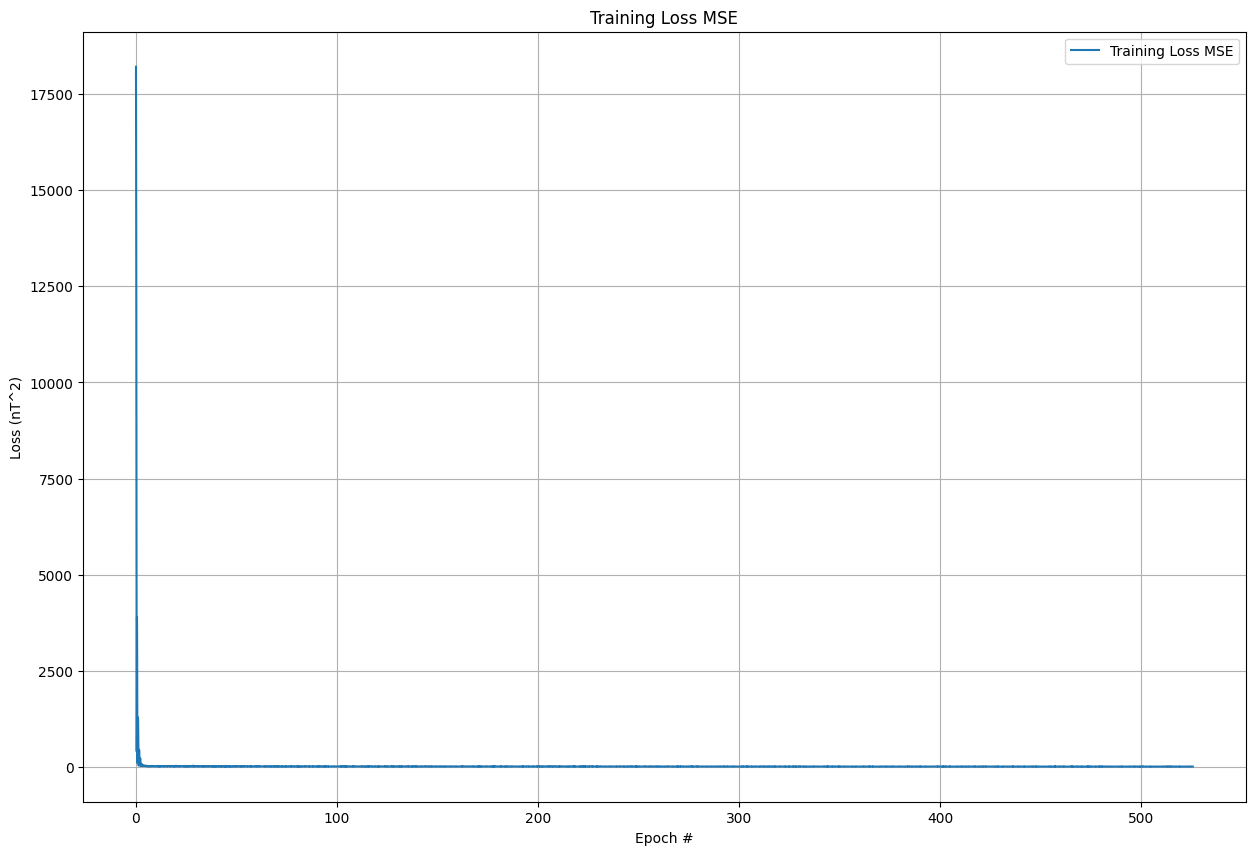

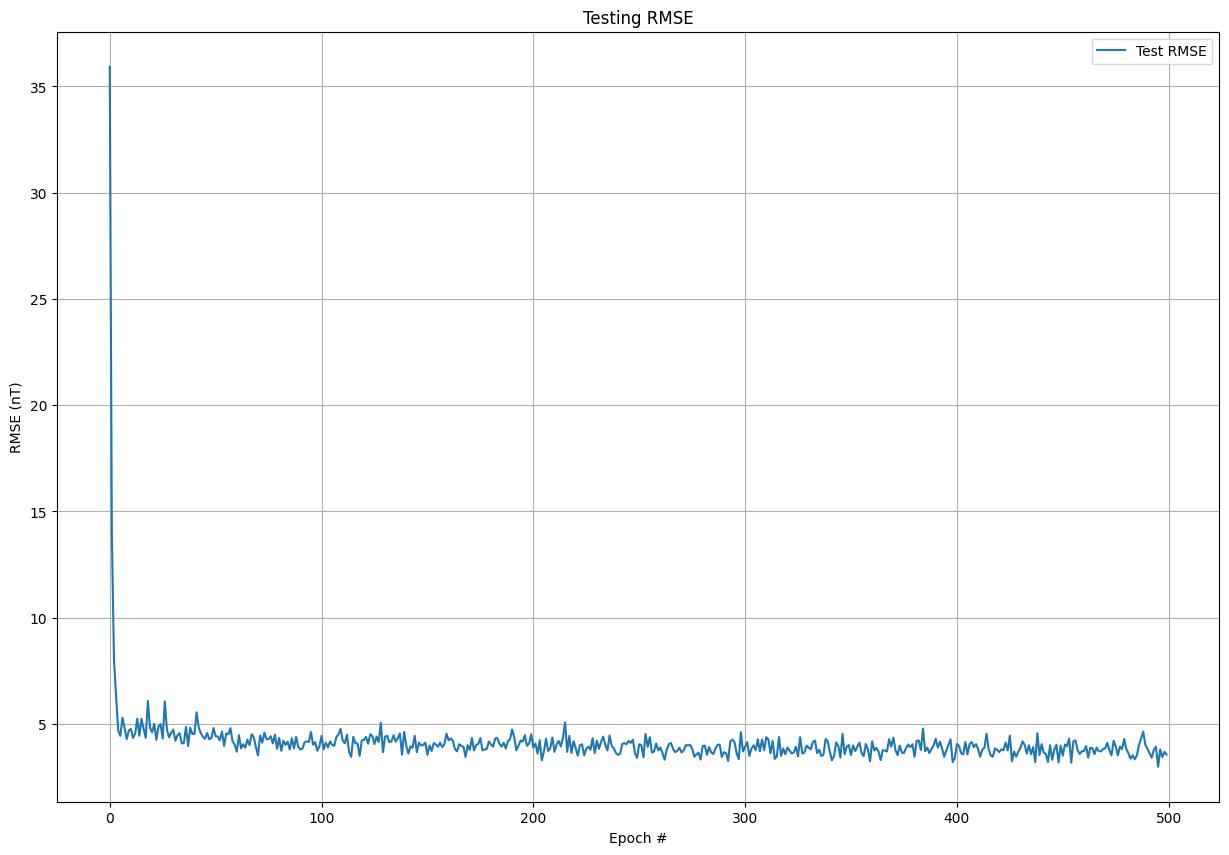

In [12]:

num_batch = len(loss_hist[0])
epoch = np.arange(num_batch)*batch_size/len(train_loader.dataset)

plt.figure()
plt.plot(epoch,loss_hist[0],label = 'Training Loss MSE')
plt.legend()
plt.xlabel('Epoch #')
plt.ylabel('Loss (nT^2)')
plt.title('Training Loss MSE')
plt.grid()

epoch = range(num_epoch)
plt.figure()
plt.plot(epoch,val_rmse_hist[0],label = 'Test RMSE')
plt.title('Testing RMSE')
plt.xlabel('Epoch #')
plt.ylabel('RMSE (nT)')
plt.grid()
plt.legend()

# Comparison (Training)

(14288,) (14288,)
(14288,) (14288,)
(14288,) (14288,)
(14288,) (14288,)
(14288,) (14288,)
(14288,) (14288,)
RMSE linear: 4.911569757307391
RMSE knn: 6.475263803523551
RMSE linear: [5.965184331993487, 4.922102848882136, 5.617779469692768, 5.623384952047325, 3.1776248459589556, 3.5117538992928536, 4.368661353448113, 3.974149451322054, 2.8783471070719724, 7.437716491675848]
RMSE knn: [6.4393926993683515, 5.971580607007719, 6.57690559534803, 6.8320150252761245, 5.237856818541527, 6.1919418238091035, 7.204078230042725, 6.146168709247241, 5.975917352363856, 7.916932055968874]
RMSE linear Kp [<4, >=4]: [3.7037680816550567, 7.902925695017816]
RMSE knn: Kp [<4, >=4] [5.609035774791363, 8.971659318453687]


1

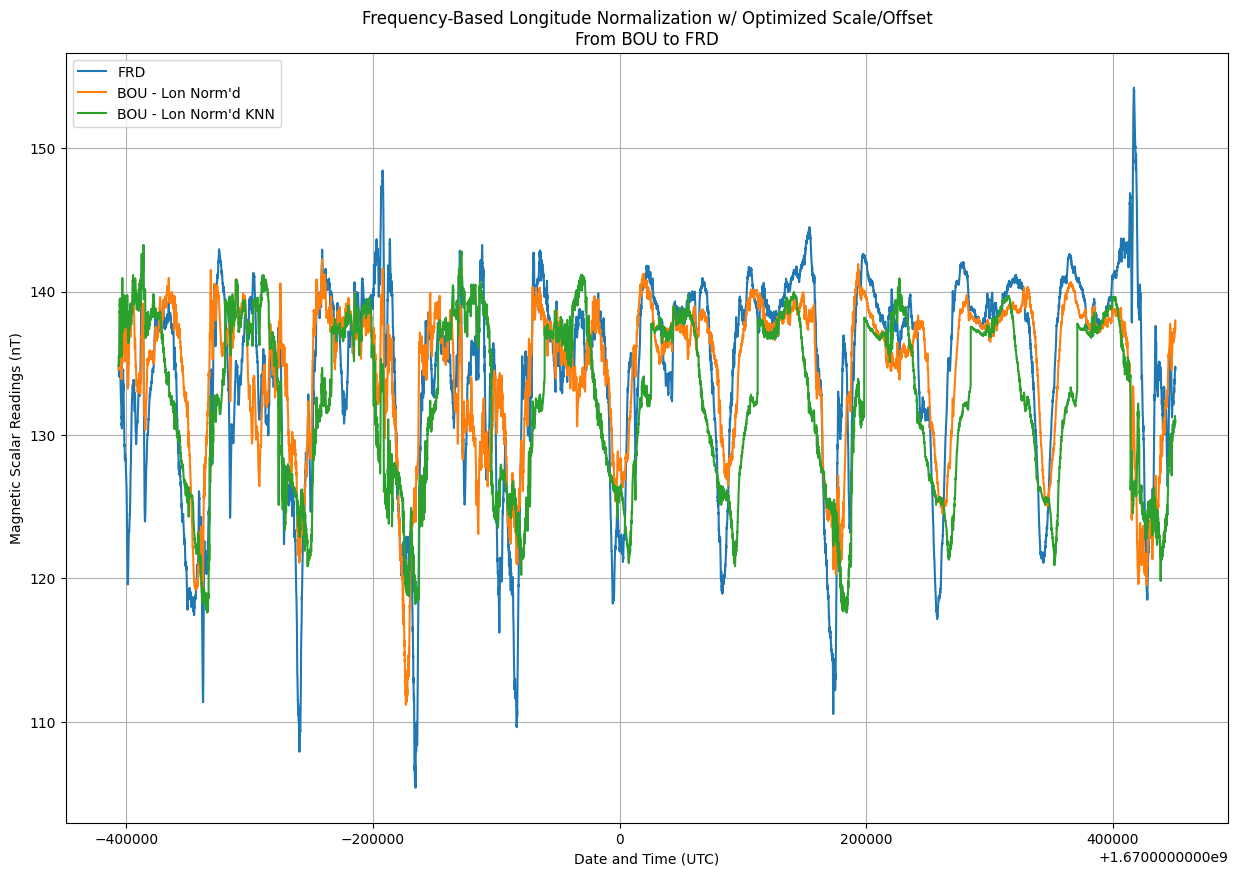

In [13]:

original_data = neural_net.x_tensor(from_combined_t, from_combined_f_no_core)
with torch.no_grad():
    prediction = np.hstack(neural_net(original_data).numpy()).tolist()
 # TODODODO_______________________________________-----------------------------------

plt.figure()
plt.title('Frequency-Based Longitude Normalization w/ Optimized Scale/Offset\nFrom ' + from_name + ' to ' + to_name)
plt.xlabel('Date and Time (UTC)')
plt.ylabel('Magnetic Scalar Readings (nT)')
plt.plot(to_df.epoch_sec[interp_mask], to_f_no_core[interp_mask], label=to_name)
plt.plot(from_combined_t, from_combined_opt_f, label='{} - Lon Norm\'d'.format(from_name))
plt.plot(from_combined_t, prediction, label='{} - Lon Norm\'d KNN'.format(from_name))
plt.legend()
plt.grid()



# Calculate Root Mean Square Error
rmse_linear= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f)
rmse_knn= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction)

rmse_linear_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'day')
rmse_knn_broken= different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'day')

rmse_kp_linear = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,from_combined_opt_f,'Kp')
rmse_kp_knn = different_time_rmse(to_df.epoch_sec[interp_mask],to_f_no_core[interp_mask],from_combined_t,prediction,'Kp')

print('RMSE linear:', rmse_linear)
print('RMSE knn:', rmse_knn)

print('RMSE linear:', rmse_linear_broken)
print('RMSE knn:', rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', rmse_kp_knn)


first_data_list = [from_name, to_name, start_tra, end_tra, offset, scale, rmse_linear, rmse_knn]
first_data_list.extend(rmse_linear_broken)
first_data_list.extend(rmse_knn_broken)
first_data_list.extend(rmse_kp_linear)
first_data_list.extend(rmse_kp_knn)
out_file.write(','.join(map(str,first_data_list)))
out_file.write(',')


# Comparison (Prediction)

# Test Optimal Parameters for Next Day's Data

(9959,) (9959,)
(9959,) (9959,)
RMSE linear: 3.32370140328039
RMSE knn: 6.8756430460847895
(9959,) (9959,)
(9959,) (9959,)
(9959,) (9959,)
(9959,) (9959,)
RMSE linear: [4.755793151136674, 3.584823435573961, 2.6781190235493932, 3.9074873110905997, 3.085315340664223, 1.7814533707190834, 2.6180906820768794]
RMSE knn: [8.784085825990328, 7.436059357870747, 6.582159858895475, 6.0795706909654195, 6.069913746632386, 6.261741473377403, 6.476316533683145]
RMSE linear Kp [<4, >=4]: [3.0824917344760454, 7.192926973396402]
RMSE knn: Kp [<4, >=4] [6.670391618148534, 10.976801227292146]


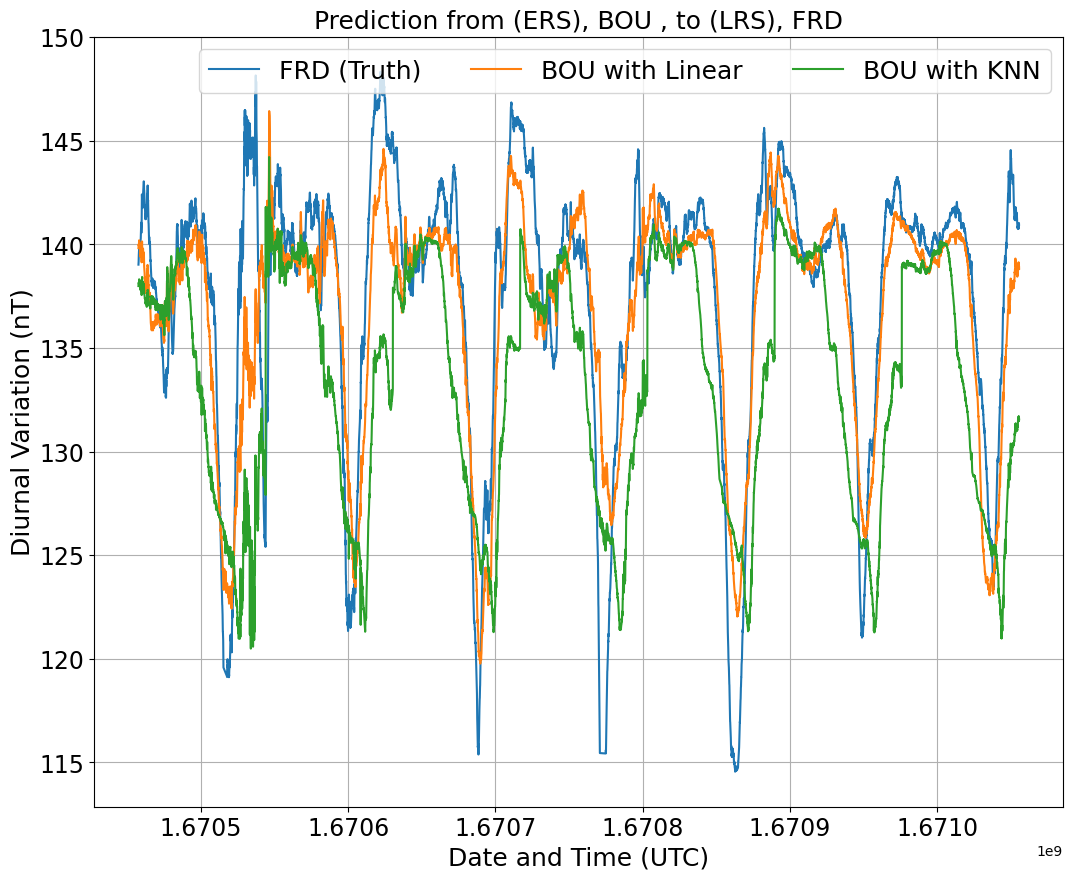

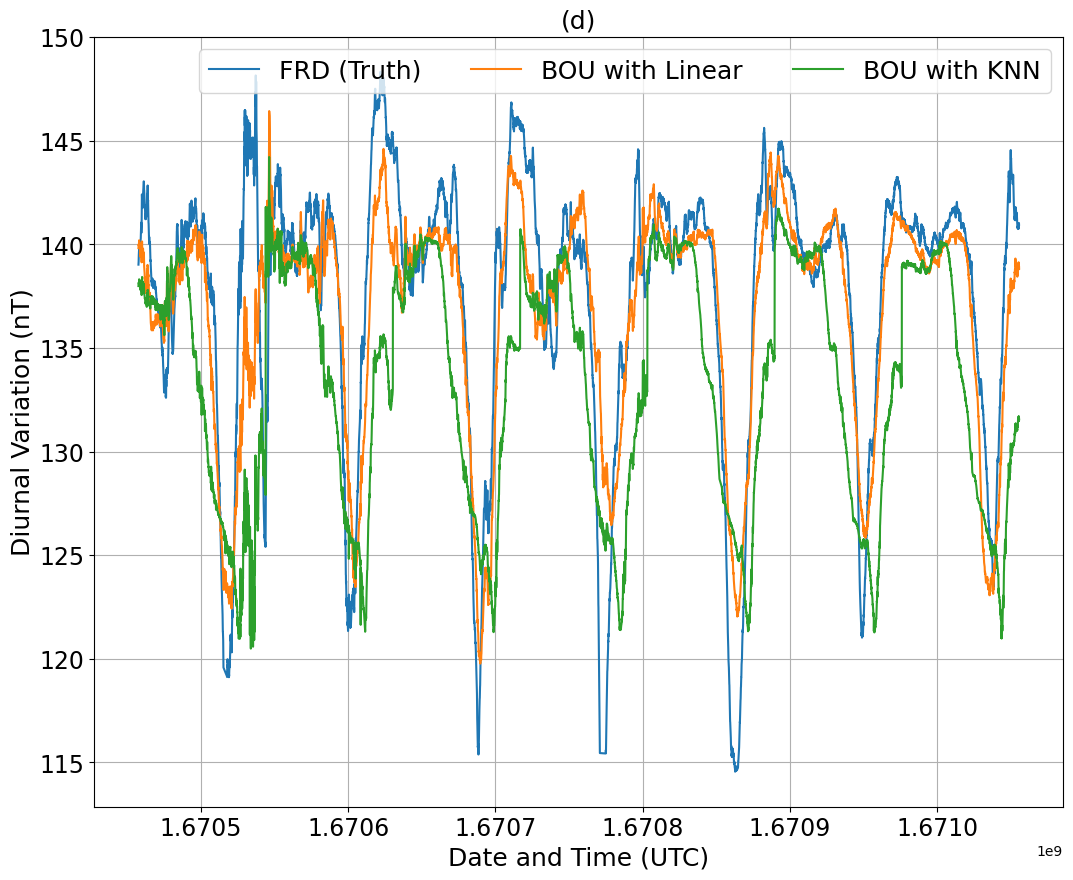

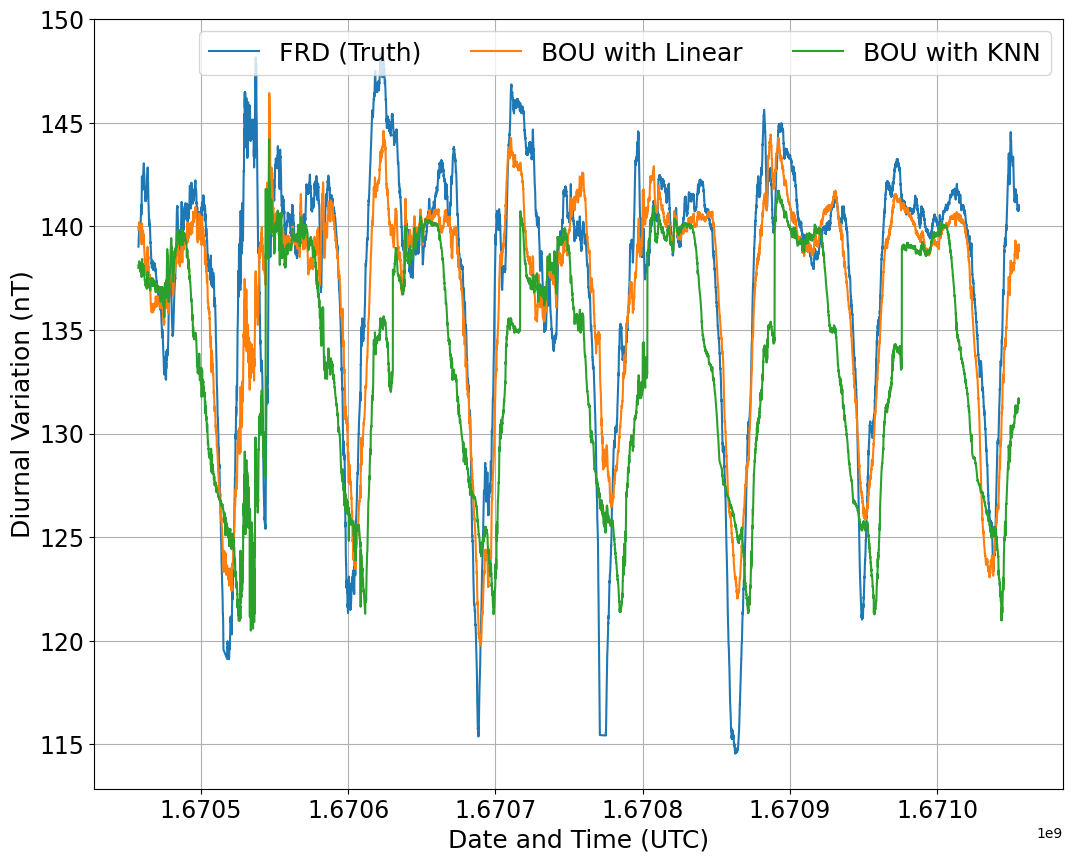

In [14]:
pred_data = neural_net.x_tensor(from_combined_t_pred, from_combined_f_no_core_pred)
with torch.no_grad():
    prediction_pred = np.hstack(neural_net(pred_data).numpy()).tolist()
font = 18
plt.figure(figsize = (12.5,10))
plt.title('Prediction from (ERS), ' + from_name  +  ' , to (LRS), ' + to_name, fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol=3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.title('(d)', fontsize = font)
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

plt.figure(figsize = (12.5,10))
plt.xlabel('Date and Time (UTC)', fontsize = font)
plt.ylabel('Diurnal Variation (nT)', fontsize = font)
plt.plot(to_df_pred.epoch_sec[interp_mask_pred], to_f_no_core_pred[interp_mask_pred], label='{} (Truth)'.format(to_name))
plt.plot(from_combined_t_pred, from_combined_opt_f_pred, label='{} with Linear'.format(from_name))
plt.plot(from_combined_t_pred, prediction_pred, label='{} with KNN'.format(from_name))
plt.legend(fontsize = font, ncol = 3)
plt.xticks(fontsize = font-1)
plt.yticks(fontsize = font-1)
plt.grid()

# Calculate Root Mean Square Error
next_rmse_linear= different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred)
next_rmse_knn= different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred)

print('RMSE linear:', next_rmse_linear)
print('RMSE knn:', next_rmse_knn)


next_rmse_linear_broken = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred, 'day')
next_rmse_knn_broken = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred, 'day')

next_rmse_kp_linear = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,from_combined_opt_f_pred, 'Kp')
next_rmse_kp_knn = different_time_rmse(to_df_pred.epoch_sec[interp_mask_pred],to_f_no_core_pred[interp_mask_pred],from_combined_t_pred,prediction_pred, 'Kp')

print('RMSE linear:', next_rmse_linear_broken)
print('RMSE knn:', next_rmse_knn_broken)

print('RMSE linear Kp [<4, >=4]:', next_rmse_kp_linear)
print('RMSE knn: Kp [<4, >=4]', next_rmse_kp_knn)

second_data_list = [start_tst, end_tst, next_rmse_linear, next_rmse_knn]
second_data_list.extend(next_rmse_linear_broken)
second_data_list.extend(next_rmse_knn_broken)
second_data_list.extend(next_rmse_kp_linear)
second_data_list.extend(next_rmse_kp_knn)
out_file.write(','.join(map(str,second_data_list)))
out_file.write('\n')
out_file.close()